# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4
# Regularization, High Dimensionality, PCA


**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

---

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- Restart the kernel and run the whole notebook again before you submit. 
- Do not include your name(s) in the notebook even if you are submitting as a group. 
- If you submit individually and you have worked with someone, please include the name of your [one] partner below. 

---

Your partner's name (if you submit separately):

Enrollment Status (109A, 121A, 209A, or E109A):

### NOTE: I did everything all by myself, except that the first problem in advanced section (MLE problem), I discussed with my classmate Jiawen Tong, who also enrolled in 209A.

Import libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

/Applications/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Continuing Bike Sharing Usage Data

In this homework, we will focus on multiple linear regression, regularization, dealing with high dimensionality, and PCA. We will continue to build regression models for the Capital Bikeshare program in Washington D.C.  See Homework 3 for more information about the data.

*Note: please make sure you use all the processed data from HW 3 Part (a)...you make want to save the data set on your computer and reread the csv/json file here.


## Part (f): Regularization/Penalization Methods

As an alternative to selecting a subset of predictors and fitting a regression model on the subset, one can fit a linear regression model on all predictors, but shrink or regularize the coefficient estimates to make sure that the model does not "overfit" the training set. 

Use the following regularization techniques to fit linear models to the training set:
- Ridge regression
- Lasso regression
    
You may choose the shrikage parameter $\lambda$ from the set $\{10^{-5}, 10^{-4},...,10^{4},10^{5}\}$ using cross-validation. In each case, 

- How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.

We next analyze the performance of the two shrinkage methods for different training sample sizes:
- Generate random samples of sizes 100, 150, ..., 400 from the training set. You may use the following code to draw a random sample of a specified size from the training set:

In [2]:
#--------  sample
# A function to select a random sample of size k from the training set
# Input: 
#      x (n x d array of predictors in training data)
#      y (n x 1 array of response variable vals in training data)
#      k (size of sample) 
# Return: 
#      chosen sample of predictors and responses

def sample(x, y, k):
    n = x.shape[0] # No. of training points
    
    # Choose random indices of size 'k'
    subset_ind = np.random.choice(np.arange(n), k)
    
    # Get predictors and reponses with the indices
    x_subset = x[subset_ind, :]
    y_subset = y[subset_ind]
    
    return (x_subset, y_subset)

In [3]:
df_bike_train=pd.read_csv("data/Bikeshare_train.csv", index_col = 0)
df_bike_test=pd.read_csv("data/Bikeshare_test.csv", index_col = 0)

df_bike_train['season'] = df_bike_train['season'].astype("category")
df_bike_train['month'] = df_bike_train['month'].astype("category")
df_bike_train['holiday'] = df_bike_train['holiday'].astype("category")
df_bike_train['day_of_week'] = df_bike_train['day_of_week'].astype("category")
df_bike_train['workingday'] = df_bike_train['workingday'].astype("category")
df_bike_train['weather'] = df_bike_train['weather'].astype("category")

df_train = pd.get_dummies(df_bike_train,columns=["season","month","holiday","day_of_week","workingday","weather"],\
                             drop_first = True)
# Rename the columns
df_train = df_train.rename(columns={"season_2.0": "Summer", "season_3.0": "Fall", "season_4.0": "Winter",\
                                    "month_2.0": "Feb", "month_3.0": "Mar", "month_4.0": "Apr", "month_5.0": "Mar", \
                                    "month_6.0": "Jun", "month_7.0": "Jul", "month_8.0": "Aug", "month_9.0": "Sep", \
                                    "month_10.0": "Oct", "month_11.0": "Nov", "month_12.0": "Dec", \
                                    "holiday_1.0": "Holiday", "day_of_week_1.0": "Mon", "day_of_week_2.0": "Tue", \
                                    "day_of_week_3.0": "Wed", "day_of_week_4.0": "Thu", "day_of_week_5.0": "Fri", \
                                    "day_of_week_6.0": "Sat", "workingday_1.0": "Workday", \
                                    "weather_2.0": "Mist", "weather_3.0": "Light_rain/snow"})

df_bike_test['season'] = df_bike_test['season'].astype("category")
df_bike_test['month'] = df_bike_test['month'].astype("category")
df_bike_test['holiday'] = df_bike_test['holiday'].astype("category")
df_bike_test['day_of_week'] = df_bike_test['day_of_week'].astype("category")
df_bike_test['workingday'] = df_bike_test['workingday'].astype("category")
df_bike_test['weather'] = df_bike_test['weather'].astype("category")
df_test = pd.get_dummies(df_bike_test,columns=["season","month","holiday","day_of_week","workingday","weather"],\
                             drop_first = True)
df_test = df_test.rename(columns={"season_2.0": "Summer", "season_3.0": "Fall", "season_4.0": "Winter",\
                                    "month_2.0": "Feb", "month_3.0": "Mar", "month_4.0": "Apr", "month_5.0": "Mar", \
                                    "month_6.0": "Jun", "month_7.0": "Jul", "month_8.0": "Aug", "month_9.0": "Sep", \
                                    "month_10.0": "Oct", "month_11.0": "Nov", "month_12.0": "Dec", \
                                    "holiday_1.0": "Holiday", "day_of_week_1.0": "Mon", "day_of_week_2.0": "Tue", \
                                    "day_of_week_3.0": "Wed", "day_of_week_4.0": "Thu", "day_of_week_5.0": "Fri", \
                                    "day_of_week_6.0": "Sat", "workingday_1.0": "Workday", \
                                    "weather_2.0": "Mist", "weather_3.0": "Light_rain/snow"})

# Standardize the continuous predictors to have zero mean and std of 1
temp_mean = df_train["temp"].mean()
temp_std = df_train["temp"].std()
atemp_mean = df_train["atemp"].mean()
atemp_std = df_train["atemp"].std()
humidity_mean = df_train["humidity"].mean()
humidity_std = df_train["humidity"].std()
windspeed_mean = df_train["windspeed"].mean()
windspeed_std = df_train["windspeed"].std()

df_train["temp"] = (df_train["temp"]-temp_mean) / temp_std
df_train["atemp"] = (df_train["atemp"]-atemp_mean) / atemp_std
df_train["humidity"] = (df_train["humidity"]-humidity_mean) / humidity_std
df_train["windspeed"] = (df_train["windspeed"]-windspeed_mean) / windspeed_std

df_test["temp"] = (df_test["temp"]-temp_mean) / temp_std
df_test["atemp"] = (df_test["atemp"]-atemp_mean) / atemp_std
df_test["humidity"] = (df_test["humidity"]-humidity_mean) / humidity_std
df_test["windspeed"] = (df_test["windspeed"]-windspeed_mean) / windspeed_std

In [4]:
reg_params = np.hstack((10.**np.arange(-5, 0), 10**np.arange(0, 6)))

all_predictors = [col for col in df_train.columns if col not in ['count']]
X_non_test = df_train[all_predictors].values
X_test = df_test[all_predictors].values
y_non_test = df_train['count'].values
y_test = df_test['count'].values

# ridge regression
ridge_regression = RidgeCV(alphas=reg_params, fit_intercept=True, cv=10)
ridge_regression.fit(X_non_test, y_non_test)
best_alpha_ridge = ridge_regression.alpha_

ridge_regression = Ridge(best_alpha_ridge, fit_intercept=True)
ridge_regression.fit(X_non_test, y_non_test)
test_R2_ridge = (ridge_regression.score(X_test, y_test))
print('best regularization param of ridge regression is:', best_alpha_ridge)
print('the test R^2 for ridge regression with alpha = {} is: {}'.format(best_alpha_ridge, test_R2_ridge))
# ridge_regression.coef_

ridge_coef_dict = {}
for coef, feat in zip(ridge_regression.coef_,all_predictors):
    ridge_coef_dict[feat] = coef
ridge_coef_dict

best regularization param of ridge regression is: 10.0
the test R^2 for ridge regression with alpha = 10.0 is: 0.25916368319187544


{'Apr': 87.095757683970533,
 'Aug': -297.32663540432981,
 'Dec': 507.0602274250374,
 'Fall': 180.3263570456285,
 'Feb': -109.66405274885062,
 'Fri': 124.01972674403788,
 'Holiday': 160.86537078726153,
 'Jul': 87.095757683970518,
 'Jun': 57.735360677106172,
 'Light_rain/snow': 217.35903972738168,
 'Mar': 386.87905758684428,
 'Mist': 304.04445800825914,
 'Mon': -98.036521704947432,
 'Nov': 681.64251738730604,
 'Oct': -84.498114262292304,
 'Sat': 64.973634889616889,
 'Sep': -523.90153294447691,
 'Summer': 379.79554800137095,
 'Thu': -127.57898546592375,
 'Tue': -158.72155217982134,
 'Wed': -129.21331437178259,
 'Winter': 768.6368787950895,
 'Workday': 126.4364257516126,
 'atemp': 552.08958819002919,
 'humidity': -568.5643990851521,
 'temp': 681.47619052606842,
 'windspeed': -266.37098474239252}

In [5]:
# lasso regression
lasso_regression = LassoCV(alphas=reg_params, fit_intercept=True, cv=10)
lasso_regression.fit(X_non_test, y_non_test)
best_alpha_lasso = lasso_regression.alpha_

lasso_regression = Lasso(best_alpha_lasso, fit_intercept=True)
lasso_regression.fit(X_non_test, y_non_test)
test_R2_lasso = (lasso_regression.score(X_test, y_test))
print('best regularization param of lasso regression is:', best_alpha_lasso)
print('the test R^2 for lasso regression with alpha = {} is: {}'.format(best_alpha_lasso, test_R2_lasso))
# lasso_regression.coef_

lasso_coef_dict = {}
for coef, feat in zip(lasso_regression.coef_,all_predictors):
    lasso_coef_dict[feat] = coef
lasso_coef_dict

best regularization param of lasso regression is: 10.0
the test R^2 for lasso regression with alpha = 10.0 is: 0.2675652604208182


/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


{'Apr': 0.0,
 'Aug': -354.59967520106005,
 'Dec': 483.88135905073193,
 'Fall': 113.79215890494025,
 'Feb': -0.0,
 'Fri': 17.595754799677806,
 'Holiday': 68.021384114413138,
 'Jul': 0.0,
 'Jun': 0.0,
 'Light_rain/snow': 277.51683129397497,
 'Mar': 312.53474322631729,
 'Mist': 309.94970236692467,
 'Mon': -0.0,
 'Nov': 834.58482619962683,
 'Oct': -0.0,
 'Sat': 0.0,
 'Sep': -496.15244944310183,
 'Summer': 543.88043347632845,
 'Thu': -129.13774134766413,
 'Tue': -0.0,
 'Wed': -178.96323752722822,
 'Winter': 898.94180240673666,
 'Workday': 11.33485061501047,
 'atemp': 399.36842831642298,
 'humidity': -555.84068590791424,
 'temp': 854.72917486646202,
 'windspeed': -254.36861533866838}

In [6]:
lasso_zero_coef = {}
for k, v in lasso_coef_dict.items():
    if abs(v) < 10**(-10):
        lasso_zero_coef[k] = v
lasso_zero_coef

{'Apr': 0.0,
 'Feb': -0.0,
 'Jul': 0.0,
 'Jun': 0.0,
 'Mon': -0.0,
 'Oct': -0.0,
 'Sat': 0.0,
 'Tue': -0.0}

## Answer:

### How do the estimated coefficients compare to or differ from the coefficients estimated by a plain linear regression (without shrikage penalty) in Part (b) fropm HW 3? Is there a difference between coefficients estimated by the two shrinkage methods? If so, give an explantion for the difference.
- The estimated coefficients shrinked compared to the ones using plain linear regression.

- Using Lasso regression, some coefficients become zero, while Ridge regression will never shrink coefficients to zero. This is because Ridge uses L2 norm while Lasso uses L1 norm. As the two pictures showed in class, using Ridge to minimize the contours, it will get tangent to the circle (due to L2 norm). But using Lasso to minimize the contours, it is very likely to land on a corner (a square diamond due to L1 norm).

### List the predictors that are assigned a coefficient value close to 0 (say < 1e-10) by the two methods. How closely do these predictors match the redundant predictors (if any) identified in Part (c) from HW 3?
- Ridge regression does not assign any coefficient value close to 0, but Lasso assigns a bunch of zeros for the coefficients, including a few months and a few days in a week. These are redundant predictors identified in part (c) from the heatmap.

### Is there a difference in the way Ridge and Lasso regression assign coefficients to the predictors `temp` and `atemp`? If so, explain the reason for the difference.
- Ridge assigned "temp" with 681 and "atemp" with 552, whereas Lasso assigned "temp" with 854 and "atemp" with "399".
- These two predictors "temp" and "atemp" are highly correlated and the difference that Ridge and Lasso assign coefficients to them is because they use two different penalty functions: Ridge uses L2 norm and Lasso uses L1 norm. So Ridge can only help with shrinkage but Lasso does both shrinkage and predictor selection. And that's why the difference between coefficient values are bigger in Lasso than in Ridge. Lasso is telling us to choose "temp" over "atemp".

In [7]:
all_predictors = [col for col in df_train.columns if col not in ['count']]
X_train = df_train[all_predictors].values
X_test = df_test[all_predictors].values
y_train = df_train['count'].values
y_test = df_test['count'].values

linear_regression = LinearRegression(fit_intercept=True)
ridge_regression = Ridge(best_alpha_ridge, fit_intercept=True)
lasso_regression = Lasso(best_alpha_lasso, fit_intercept=True)

sample_sizes = [100,150,200,250,300,350,400]

for i in sample_sizes:
    X_train_sample, y_train_sample = sample(X_train, y_train, i)
    linear_regression.fit(X_train_sample, y_train_sample)
    print("sample size =", i)
    print("Linear Regression Model: train R^2 score:{} and test R^2 score:{}".\
          format(linear_regression.score(X_train_sample, y_train_sample), linear_regression.score(X_test, y_test)))
    ridge_regression.fit(X_train_sample, y_train_sample)
    print("Ridge Regression Model: train R^2 score:{} and test R^2 score:{}".\
          format(ridge_regression.score(X_train_sample, y_train_sample), ridge_regression.score(X_test, y_test)))
    lasso_regression.fit(X_train_sample, y_train_sample)
    print("Lasso Regression Model: train R^2 score:{} and test R^2 score:{}".\
          format(lasso_regression.score(X_train_sample, y_train_sample), lasso_regression.score(X_test, y_test)))

sample size = 100
Linear Regression Model: train R^2 score:0.6828307202750855 and test R^2 score:0.13495819870645398
Ridge Regression Model: train R^2 score:0.6156194430990063 and test R^2 score:0.22496068829122984
Lasso Regression Model: train R^2 score:0.6650729726200361 and test R^2 score:0.18739261006968744
sample size = 150
Linear Regression Model: train R^2 score:0.6275579500319868 and test R^2 score:0.18719652453232416
Ridge Regression Model: train R^2 score:0.5874924863750719 and test R^2 score:0.250316788904012
Lasso Regression Model: train R^2 score:0.6005993669417939 and test R^2 score:0.23652605270338856
sample size = 200
Linear Regression Model: train R^2 score:0.6839949308025381 and test R^2 score:0.10413072743788554
Ridge Regression Model: train R^2 score:0.6248718740470418 and test R^2 score:0.20753122109914146
Lasso Regression Model: train R^2 score:0.663633545222564 and test R^2 score:0.1806910565134202
sample size = 250
Linear Regression Model: train R^2 score:0.6033

- Fit linear, Ridge and Lasso regression models to each of the generated sample. In each case, compute the $R^2$ score for the model on the training sample on which it was fitted, and on the test set.
- Repeat the above experiment for 10 random trials/splits, and compute the average train and test $R^2$ across the trials for each training sample size. Also, compute the standard deviation (SD) in each case.
- Make a plot of the mean training $R^2$ scores for the linear, Ridge and Lasso regression methods as a function of the training sample size. Also, show a confidence interval for the mean scores extending from **mean - SD** to **mean + SD**. Make a similar plot for the test $R^2$ scores.

How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. How do the confidence intervals for the estimated $R^2$ change with training sample size? Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?

*Hint:* You may use `sklearn`'s `RidgeCV` and `LassoCV` classes to implement Ridge and Lasso regression. These classes automatically perform cross-validation to tune the parameter $\lambda$ from a given range of values. You may use the `plt.errorbar` function to plot confidence bars for the average $R^2$ scores.

In [8]:
# your code here
train_linear_mean = []
train_linear_sd = []
test_linear_mean = []
test_linear_sd = []

train_ridge_mean = []
train_ridge_sd = []
test_ridge_mean = []
test_ridge_sd = []

train_lasso_mean = []
train_lasso_sd = []
test_lasso_mean = []
test_lasso_sd = []

for i in sample_sizes:
    train_R2_linear = []
    test_R2_linear = []
    train_R2_ridge = []
    test_R2_ridge = []
    train_R2_lasso = []
    test_R2_lasso = []
    for j in range(0,10):
        X_train_sample, y_train_sample = sample(X_train, y_train, i)
        
        linear_regression.fit(X_train_sample, y_train_sample)
        train_R2_linear.append(linear_regression.score(X_train_sample, y_train_sample))
        test_R2_linear.append(linear_regression.score(X_test, y_test))
        
        ridge_regression.fit(X_train_sample, y_train_sample)
        train_R2_ridge.append(ridge_regression.score(X_train_sample, y_train_sample))
        test_R2_ridge.append(ridge_regression.score(X_test, y_test))
        
        lasso_regression.fit(X_train_sample, y_train_sample)
        train_R2_lasso.append(lasso_regression.score(X_train_sample, y_train_sample))
        test_R2_lasso.append(lasso_regression.score(X_test, y_test))
    
    train_linear_mean.append(np.mean(train_R2_linear))
    train_linear_sd.append(np.std(train_R2_linear))
    test_linear_mean.append(np.mean(test_R2_linear))
    test_linear_sd.append(np.std(test_R2_linear))
    
    train_ridge_mean.append(np.mean(train_R2_ridge))
    train_ridge_sd.append(np.std(train_R2_ridge))
    test_ridge_mean.append(np.mean(test_R2_ridge))
    test_ridge_sd.append(np.std(test_R2_ridge))
    
    train_lasso_mean.append(np.mean(train_R2_lasso))
    train_lasso_sd.append(np.std(train_R2_lasso))
    test_lasso_mean.append(np.mean(test_R2_lasso))
    test_lasso_sd.append(np.std(test_R2_lasso))

print("Mean and std of train R^2 using Linear Regression Model:")
for i, e in enumerate(train_linear_mean):
    print("sample size =", sample_sizes[i], ": mean =", train_linear_mean[i], ", std =", train_linear_sd[i])
print("Mean and std of test R^2 using Linear Regression Model:")
for i, e in enumerate(test_linear_mean):
    print("sample size =", sample_sizes[i], ": mean =", test_linear_mean[i], ", std =", test_linear_sd[i])

Mean and std of train R^2 using Linear Regression Model:
sample size = 100 : mean = 0.704007982268 , std = 0.0441575099717
sample size = 150 : mean = 0.675122326881 , std = 0.0456612130526
sample size = 200 : mean = 0.661529009931 , std = 0.0432961651945
sample size = 250 : mean = 0.617241694474 , std = 0.0344914642984
sample size = 300 : mean = 0.637662893224 , std = 0.0248466308915
sample size = 350 : mean = 0.60847893431 , std = 0.0323871120137
sample size = 400 : mean = 0.608540843389 , std = 0.0338304737311
Mean and std of test R^2 using Linear Regression Model:
sample size = 100 : mean = 0.00976889722639 , std = 0.102103228399
sample size = 150 : mean = 0.123235150593 , std = 0.0615185437167
sample size = 200 : mean = 0.164485164398 , std = 0.047467498761
sample size = 250 : mean = 0.176678635199 , std = 0.0443161260455
sample size = 300 : mean = 0.195170125808 , std = 0.0329809784014
sample size = 350 : mean = 0.205285244457 , std = 0.0329114027856
sample size = 400 : mean = 0.2

In [9]:
print("Mean and std of train R^2 using Ridge Regression Model:")
for i, e in enumerate(train_ridge_mean):
    print("sample size =", sample_sizes[i], ": mean =", train_ridge_mean[i], ", std =", train_ridge_sd[i])
print("Mean and std of test R^2 using Ridge Regression Model:")
for i, e in enumerate(test_ridge_mean):
    print("sample size =", sample_sizes[i], ": mean =", test_ridge_mean[i], ", std =", test_ridge_sd[i])

Mean and std of train R^2 using Ridge Regression Model:
sample size = 100 : mean = 0.609589367023 , std = 0.0513424987294
sample size = 150 : mean = 0.609148806665 , std = 0.0452668478353
sample size = 200 : mean = 0.619044737761 , std = 0.0494093643628
sample size = 250 : mean = 0.58934442641 , std = 0.0316820162034
sample size = 300 : mean = 0.609574851816 , std = 0.0258343627262
sample size = 350 : mean = 0.583496270643 , std = 0.0326383147154
sample size = 400 : mean = 0.588607494848 , std = 0.0341558810019
Mean and std of test R^2 using Ridge Regression Model:
sample size = 100 : mean = 0.22570680372 , std = 0.0245732038433
sample size = 150 : mean = 0.237479044625 , std = 0.0222647372131
sample size = 200 : mean = 0.233631592157 , std = 0.0296169012096
sample size = 250 : mean = 0.2288133288 , std = 0.0218242495215
sample size = 300 : mean = 0.235073005464 , std = 0.0195667745726
sample size = 350 : mean = 0.248914594832 , std = 0.0138849026214
sample size = 400 : mean = 0.246237

In [10]:
print("Mean and std of train R^2 using Lasso Regression Model:")
for i, e in enumerate(train_lasso_mean):
    print("sample size =", sample_sizes[i], ": mean =", train_lasso_mean[i], ", std =", train_lasso_sd[i])
print("Mean and std of test R^2 using Lasso Regression Model:")
for i, e in enumerate(test_lasso_mean):
    print("sample size =", sample_sizes[i], ": mean =", test_lasso_mean[i], ", std =", test_lasso_sd[i])

Mean and std of train R^2 using Lasso Regression Model:
sample size = 100 : mean = 0.679507451403 , std = 0.0495712490229
sample size = 150 : mean = 0.655846236478 , std = 0.0489472747105
sample size = 200 : mean = 0.643159438781 , std = 0.0452653446902
sample size = 250 : mean = 0.60253311129 , std = 0.0329436754757
sample size = 300 : mean = 0.622530979058 , std = 0.0270500398432
sample size = 350 : mean = 0.592035832868 , std = 0.0319306273309
sample size = 400 : mean = 0.592472365723 , std = 0.0345898587077
Mean and std of test R^2 using Lasso Regression Model:
sample size = 100 : mean = 0.143698579702 , std = 0.0607229984285
sample size = 150 : mean = 0.194196181255 , std = 0.0413636646749
sample size = 200 : mean = 0.220620354589 , std = 0.0371241937857
sample size = 250 : mean = 0.217854698063 , std = 0.0282562211058
sample size = 300 : mean = 0.228362914395 , std = 0.028870858783
sample size = 350 : mean = 0.249641311855 , std = 0.0169955087941
sample size = 400 : mean = 0.2493

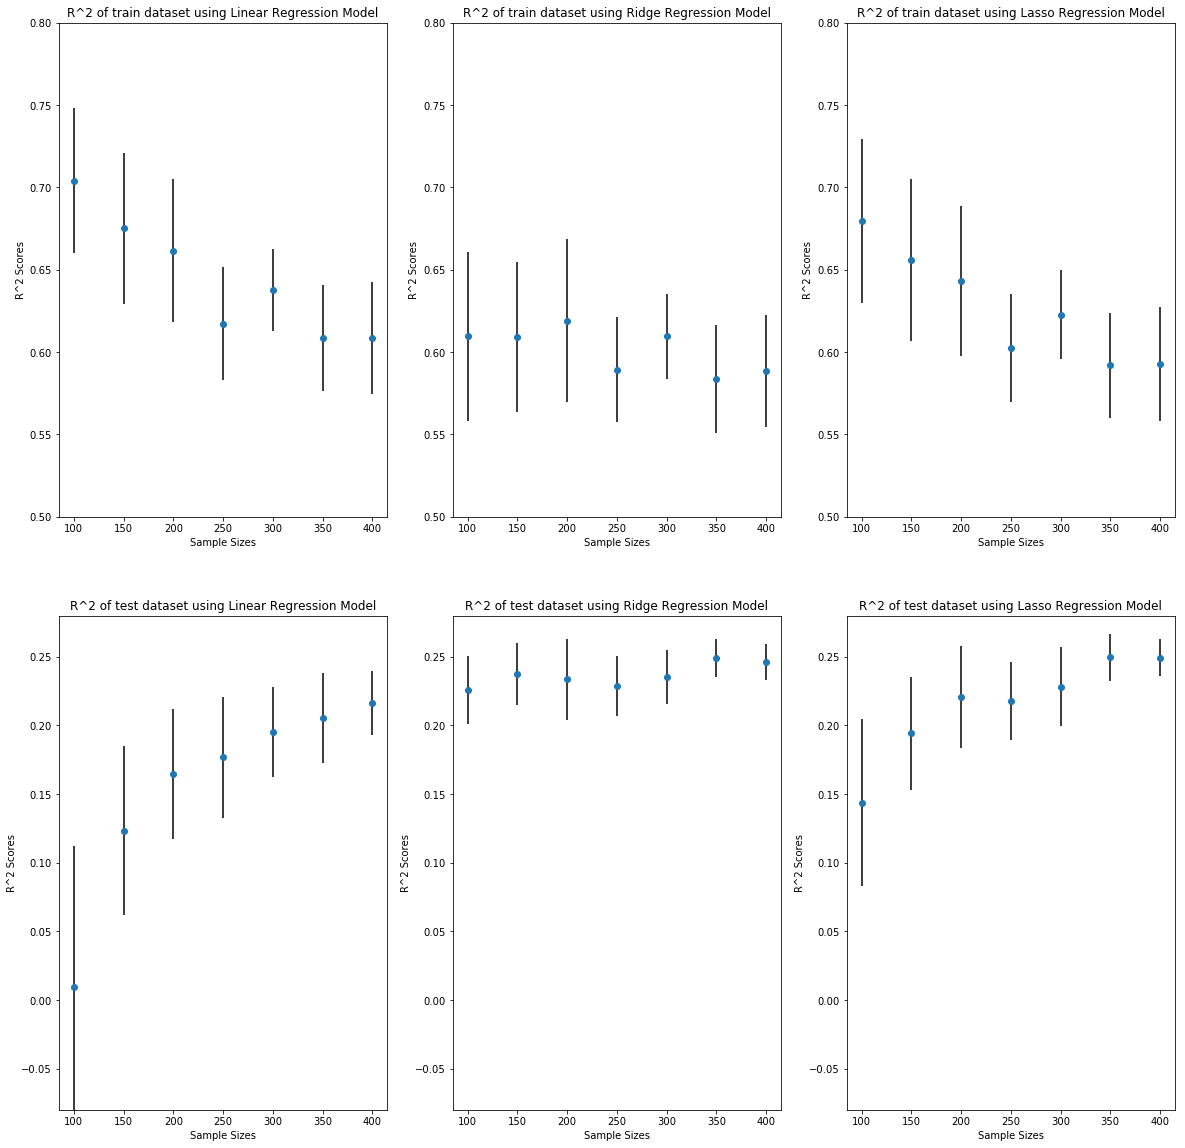

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 20))
ax = axs[0,0]
ax.set_xticks(np.arange(len(sample_sizes)))
ax.set_xticklabels(sample_sizes)
ax.errorbar(np.arange(len(sample_sizes)), train_linear_mean, yerr=train_linear_sd, ecolor="black", fmt='o')
ax.set_title("R^2 of train dataset using Linear Regression Model")
ax.set_xlabel("Sample Sizes")
ax.set_ylabel("R^2 Scores")
ax.set_ylim(0.5, 0.8)

ax = axs[1,0]
ax.set_xticks(np.arange(len(sample_sizes)))
ax.set_xticklabels(sample_sizes)
ax.errorbar(np.arange(len(sample_sizes)), test_linear_mean, yerr=test_linear_sd, ecolor="black", fmt='o')
ax.set_title("R^2 of test dataset using Linear Regression Model")
ax.set_xlabel("Sample Sizes")
ax.set_ylabel("R^2 Scores")
ax.set_ylim(-0.08, 0.28)

ax = axs[0,1]
ax.set_xticks(np.arange(len(sample_sizes)))
ax.set_xticklabels(sample_sizes)
ax.errorbar(np.arange(len(sample_sizes)), train_ridge_mean, yerr=train_ridge_sd, ecolor="black", fmt='o')
ax.set_title("R^2 of train dataset using Ridge Regression Model")
ax.set_xlabel("Sample Sizes")
ax.set_ylabel("R^2 Scores")
ax.set_ylim(0.5, 0.8)

ax = axs[1,1]
ax.set_xticks(np.arange(len(sample_sizes)))
ax.set_xticklabels(sample_sizes)
ax.errorbar(np.arange(len(sample_sizes)), test_ridge_mean, yerr=test_ridge_sd, ecolor="black", fmt='o')
ax.set_title("R^2 of test dataset using Ridge Regression Model")
ax.set_xlabel("Sample Sizes")
ax.set_ylabel("R^2 Scores")
ax.set_ylim(-0.08, 0.28)

ax = axs[0,2]
ax.set_xticks(np.arange(len(sample_sizes)))
ax.set_xticklabels(sample_sizes)
ax.errorbar(np.arange(len(sample_sizes)), train_lasso_mean, yerr=train_lasso_sd, ecolor="black", fmt='o')
ax.set_title("R^2 of train dataset using Lasso Regression Model")
ax.set_xlabel("Sample Sizes")
ax.set_ylabel("R^2 Scores")
ax.set_ylim(0.5, 0.8)

ax = axs[1,2]
ax.set_xticks(np.arange(len(sample_sizes)))
ax.set_xticklabels(sample_sizes)
ax.errorbar(np.arange(len(sample_sizes)), test_lasso_mean, yerr=test_lasso_sd, ecolor="black", fmt='o')
ax.set_title("R^2 of test dataset using Lasso Regression Model")
ax.set_xlabel("Sample Sizes")
ax.set_ylabel("R^2 Scores")
ax.set_ylim(-0.08, 0.28)

plt.show()

your answers here

## Answer:
### 1. How do the training and test $R^2$ scores compare for the three methods? Give an explanation for your observations. 
- The training R^2 scores do not differ from each other a lot among the three models. But we can still see from the plots that the plain linear regression model has the highest training R^2 score, and I think this is due to the problem of overfitting. Using the two regularization methods, ridge and lasso, training R^2 scores decrease a little bit.
- The plain linear regression model gives the lowest test R^2 score among the three methods, and it has wider confidence intervals than the rest two methods. I think this is because the linear regression model overfits the dataset.

### 2. How do the confidence intervals for the estimated $R^2$ change with training sample size? 
- The confidence intervals get smaller as the training sample size gets bigger. This is because bigger sample size is almost always preferaable to offer more information, so the coefficient in the model will be more reliable to model the dataset. Therefore, the confidence intervals gets smaller because we are more "confident" about the coefficients.

### 3. Based on the plots, which of the three methods would you recommend when one needs to fit a regression model using a small training sample?
- I definitely don't recommend using the plain linear regression model, because it has the problem of overfitting and we can see that the test R^2 scores, especially with a small training sample, are not high at all, which are below 0.2. Based on the plots, I will suggest using Ridge regression. We can see that its R^2 scores are very stable, even with small training sample, it is above 0.2 too. However, Lasso regression does not perform so well, as we can see the test R^2 score with sample size of 100 is below 0.15, and its confidence interval is wide too.

## Part (g): Polynomial & Interaction Terms

Moving beyond linear models, we will now try to improve the performance of the regression model in Part (b) from HW 3 by including higher-order polynomial and interaction terms. 

- For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 

- Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?

In [12]:
# your code here
gen_poly_terms = PolynomialFeatures(degree=4, interaction_only=False)
X_train_cont = df_train[["temp", "atemp", "humidity", "windspeed"]]
X_test_cont = df_test[["temp", "atemp", "humidity", "windspeed"]]
X_train_non_cont = df_train.drop(["temp", "atemp", "humidity", "windspeed", "count"], axis=1)
X_test_non_cont = df_test.drop(["temp", "atemp", "humidity", "windspeed", "count"], axis=1)
y_train = df_train['count'].values
y_test = df_test['count'].values

X_train_poly1 = gen_poly_terms.fit_transform(X_train_cont)
X_test_poly1 = gen_poly_terms.fit_transform(X_test_cont)

X_train_poly_df = pd.DataFrame(X_train_poly1)
X_test_poly_df = pd.DataFrame(X_test_poly1)

poly_names = gen_poly_terms.get_feature_names()
X_train_poly_df.columns = poly_names
X_test_poly_df.columns = poly_names
X_train_poly_df = X_train_poly_df[["x0","x0^2","x0^3","x0^4","x1","x1^2","x1^3","x1^4","x2","x2^2","x2^3","x2^4", \
                               "x3","x3^2","x3^3","x3^4"]]
X_test_poly_df = X_test_poly_df[["x0","x0^2","x0^3","x0^4","x1","x1^2","x1^3","x1^4","x2","x2^2","x2^3","x2^4", \
                               "x3","x3^2","x3^3","x3^4"]]
X_train_poly_df = X_train_poly_df.rename(columns={"x0":"temp", "x0^2":"temp^2", "x0^3":"temp^3", "x0^4":"temp^4", \
                                                 "x1":"atemp", "x1^2":"atemp^2", "x1^3":"atemp^3", "x1^4":"atemp^4", \
                                                 "x2":"humidity", "x2^2":"humidity^2", "x2^3":"humidity^3", \
                                                 "x2^4":"humidity^4", "x3":"windspeed", "x3^2":"windspeed^2", \
                                                 "x3^3":"windspeed^3", "x3^4":"windspeed^4"})
X_test_poly_df = X_test_poly_df.rename(columns={"x0":"temp", "x0^2":"temp^2", "x0^3":"temp^3", "x0^4":"temp^4", \
                                                 "x1":"atemp", "x1^2":"atemp^2", "x1^3":"atemp^3", "x1^4":"atemp^4", \
                                                 "x2":"humidity", "x2^2":"humidity^2", "x2^3":"humidity^3", \
                                                 "x2^4":"humidity^4", "x3":"windspeed", "x3^2":"windspeed^2", \
                                                 "x3^3":"windspeed^3", "x3^4":"windspeed^4"})

X_train_poly = X_train_poly_df.join(X_train_non_cont)
X_test_poly = X_test_poly_df.join(X_test_non_cont)

poly_regression_model = LinearRegression(fit_intercept=True)
poly_regression_model.fit(X_train_poly, y_train)

# y_hat_train = poly_regression_model.predict(X_train_poly)
# y_hat_test = poly_regression_model.predict(X_test_poly)
# r2_train = r2_score(y_train.reshape(-1,1), y_hat_train.reshape(-1,1))
# r2_test = r2_score(y_test.reshape(-1,1), y_hat_test.reshape(-1,1))

R2_train_poly = poly_regression_model.score(X_train_poly, y_train)
R2_test_poly = poly_regression_model.score(X_test_poly, y_test)
print("Train R^2 score is {} and test R^2 score is {}".format(R2_train_poly, R2_test_poly))

X_train_poly_sm = sm.add_constant(X_train_poly)
poly_model = sm.OLS(y_train, X_train_poly_sm)
results = poly_model.fit()
results.summary()
# all_predictors = [col for col in df_train.columns if col not in ['count']]
# all_predictors.insert(0, "constant")
# param_dict = dict(zip(all_predictors, p_values))
# sig_params_dict = {k:v for k,v in param_dict.items() if v < 0.05}
# print(sig_params_dict)

Train R^2 score is 0.6696562402214016 and test R^2 score is 0.2772384350861533


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.625
Method:                 Least Squares   F-statistic:                     15.13
Date:                Wed, 11 Oct 2017   Prob (F-statistic):           7.98e-50
Time:                        21:48:18   Log-Likelihood:                -2790.9
No. Observations:                 331   AIC:                             5662.
Df Residuals:                     291   BIC:                             5814.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5035.2713    460.417     10.936      0.000    4129.101    5941.442
temp              771.4866    760.117      1.015      0.311    -724.536    2267.510
temp^2          -1811.0180    816.910     -2.217      0.027   -3418.820    -203.216
temp^3              8.6078    275.731      0.031      0.975    -534.071     551.287
temp^4            -45.1910    171.419     -0.264      0.792    -382.570     292.188
atemp             897.2756    713.172      1.258      0.209    -506.353    2300.904
atemp^2          1175.5005    788.864      1.490      0.137    -377.102    2728.103
atemp^3          -303.9358    246.097     -1.235      0.218    -788.292     180.420
atemp^4           -20.7686    147.605     -0.141      0.888    -311.276     269.739
humidity         -668.9145    157.356     -4.251      0.000    -978.615    -359.214
humidity^2        -53.6709    155.383     -0.345      0.730    -359.488     252.146
humidity^3        -16.0576     44.892     -0.358      0.721    -104.412      72.297
humidity^4        -24.8367     31.481     -0.789      0.431     -86.796      37.122
windspeed        -446.5085    148.929     -2.998      0.003    -739.623    -153.394
windspeed^2       -34.1653    126.952     -0.269      0.788    -284.026     215.695
windspeed^3        44.8339     65.459      0.685      0.494     -83.999     173.667
windspeed^4       -20.1769     30.327     -0.665      0.506     -79.864      39.510
Summer            766.4307    454.546      1.686      0.093    -128.185    1661.046
Fall             1578.7544    519.364      3.040      0.003     556.569    2600.940
Winter           1523.2288    467.580      3.258      0.001     602.961    2443.496
Feb              -325.0686    409.611     -0.794      0.428   -1131.245     481.108
Mar              -304.8491    446.028     -0.683      0.495   -1182.700     573.002
Apr              -418.0245    639.524     -0.654      0.514   -1676.703     840.654
Mar             -1037.2042    677.186     -1.532      0.127   -2370.008     295.599
Jun             -1456.1857    697.520     -2.088      0.038   -2829.010     -83.362
Jul             -1416.9882    749.751     -1.890      0.060   -2892.610      58.634
Aug             -1715.9389    743.240     -2.309      0.022   -3178.747    -253.131
Sep             -1073.4008    660.859     -1.624      0.105   -2374.069     227.268
Oct              -925.8710    617.522     -1.499      0.135   -2141.247     289.505
Nov              -825.5328    591.138     -1.397      0.164   -1988.981     337.916
Dec              -555.6676    479.543     -1.159      0.248   -1499.481     388.146
Holiday          -189.7675    365.157     -0.520      0.604    -908.451     528.916
Mon               -93.3265    156.015     -0.598      0.550    -400.387     213.734
Tue              -133.4279    184.734     -0.722      0.471

In [13]:
results.pvalues[results.pvalues < 0.05]

const        1.504637e-23
temp^2       2.740200e-02
humidity     2.870343e-05
windspeed    2.950904e-03
Fall         2.582724e-03
Winter       1.256241e-03
Jun          3.769801e-02
Aug          2.165939e-02
Workday      2.036885e-02
dtype: float64

In [14]:
df_train_g = df_train.copy()
df_test_g = df_test.copy()
df_train_g['weather1'] = df_train_g['Mist'] + df_train_g['Light_rain/snow']
df_test_g['weather1'] = df_test_g['Mist'] + df_test_g['Light_rain/snow']

df_train_g['Dec_temp'] = df_train_g['Dec'] * df_train_g['temp']
df_test_g['Dec_temp'] = df_test_g['Dec'] * df_test_g['temp']

df_train_g['Work_w1'] = df_train_g['Workday'] * df_train_g['weather1']
df_test_g['Work_w1'] = df_test_g['Workday'] * df_test_g['weather1']

X_train_inter = df_train_g[["Dec_temp", "Work_w1"]]
X_test_inter = df_test_g[["Dec_temp", "Work_w1"]]

X_train_g = X_train_poly.join(X_train_inter)
X_test_g = X_test_poly.join(X_test_inter)

poly_regression_model = LinearRegression(fit_intercept=True)
poly_regression_model.fit(X_train_g, y_train)

R2_train_poly = poly_regression_model.score(X_train_g, y_train)
R2_test_poly = poly_regression_model.score(X_test_g, y_test)
print("Train R^2 score is {} and test R^2 score is {}".format(R2_train_poly, R2_test_poly))

X_train_g_sm = sm.add_constant(X_train_g)
poly_model = sm.OLS(y_train, X_train_g_sm)
results = poly_model.fit()
results.summary()

Train R^2 score is 0.6699675993036875 and test R^2 score is 0.2829779330240646


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     14.31
Date:                Wed, 11 Oct 2017   Prob (F-statistic):           1.07e-48
Time:                        21:48:18   Log-Likelihood:                -2790.7
No. Observations:                 331   AIC:                             5665.
Df Residuals:                     289   BIC:                             5825.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5002.8722    480.670     10.408      0.000    4056.815    5948.929
temp              795.0787    764.545      1.040      0.299    -709.704    2299.861
temp^2          -1801.8581    819.867     -2.198      0.029   -3415.526    -188.190
temp^3              1.6628    278.742      0.006      0.995    -546.958     550.284
temp^4            -44.7557    171.933     -0.260      0.795    -383.155     293.643
atemp             881.7153    717.029      1.230      0.220    -529.546    2292.976
atemp^2          1170.6729    792.462      1.477      0.141    -389.055    2730.401
atemp^3          -298.9891    247.662     -1.207      0.228    -786.439     188.461
atemp^4           -21.0470    148.500     -0.142      0.887    -313.326     271.231
humidity         -676.3519    158.504     -4.267      0.000    -988.320    -364.384
humidity^2        -56.5186    155.980     -0.362      0.717    -363.519     250.482
humidity^3        -15.0311     45.150     -0.333      0.739    -103.896      73.834
humidity^4        -23.9877     31.681     -0.757      0.450     -86.343      38.367
windspeed        -447.0797    150.175     -2.977      0.003    -742.655    -151.505
windspeed^2       -37.8573    127.862     -0.296      0.767    -289.515     213.801
windspeed^3        44.5758     65.712      0.678      0.498     -84.760     173.911
windspeed^4       -19.3589     30.476     -0.635      0.526     -79.341      40.623
Summer            763.6379    463.746      1.647      0.101    -149.110    1676.386
Fall             1564.2796    545.007      2.870      0.004     491.593    2636.966
Winter           1493.1626    505.353      2.955      0.003     498.524    2487.801
Feb              -325.7395    415.794     -0.783      0.434   -1144.107     492.628
Mar              -311.7359    465.982     -0.669      0.504   -1228.885     605.413
Apr              -429.5823    676.680     -0.635      0.526   -1761.428     902.264
Mar             -1024.8594    711.364     -1.441      0.151   -2424.970     375.251
Jun             -1466.6541    734.348     -1.997      0.047   -2912.002     -21.306
Jul             -1427.6739    798.423     -1.788      0.075   -2999.136     143.788
Aug             -1720.6375    791.728     -2.173      0.031   -3278.922    -162.353
Sep             -1055.9093    726.079     -1.454      0.147   -2484.983     373.165
Oct              -882.2336    692.220     -1.274      0.204   -2244.665     480.198
Nov              -773.6133    656.762     -1.178      0.240   -2066.257     519.030
Dec              -480.9222   1027.332     -0.468      0.640   -2502.924    1541.080
Holiday          -198.1240    367.617     -0.539      0.590    -921.670     525.422
Mon               -83.8820    157.901     -0.531      0.596    -394.663     226.899
Tue              -124.6199    186.989     -0.666      0.506

In [15]:
results.pvalues[results.pvalues < 0.05]

const        9.373748e-22
temp^2       2.876055e-02
humidity     2.687093e-05
windspeed    3.156613e-03
Fall         4.405070e-03
Winter       3.387359e-03
Jun          4.673872e-02
Aug          3.057212e-02
Workday      2.453842e-02
dtype: float64

your answers here

## Answer:
### 1. For each continuous predictor $X_j$, include additional polynomial terms $X^2_j$, $X^3_j$, and $X^4_j$, and fit a multiple regression model to the expanded training set. How does the $R^2$ of this model on the test set compare with that of the linear model fitted in Part (b) from HW 3? Using a t-test, find out which of estimated coefficients for the polynomial terms are statistically significant at a significance level of 5%. 
- Part (b) from HW3 gives R^2 score on the test set 0.249342111465, and with additional polynomial terms, now the test R^2 score is 0.2772384350861533. The test R^2 score improved just a little bit, but now we face a more severe problem of overfitting compared to the plain linear regression model.

- From the summary table, we can see that the only polynomial term that has a significant level of 5% is temp^2.

### 2. Fit a multiple linear regression model with additional interaction terms $\mathbb{I}_{month = 12} \times temp$ and $\mathbb{I}_{workingday = 1} \times \mathbb{I}_{weathersit = 1}$ and report the test $R^2$ for the fitted model. How does this compare with the $R^2$ obtained using linear model in Part (b) from HW 3? Are the estimated coefficients for the interaction terms statistically significant at a significance level of 5%?
- The test R^2 score for this model with two additional interaction terms is 0.2829779330240646, compared to the R^2 score of 0.249342111465 in HW3 part (b).

- We can see from the last two lines in the summary table that the two interaction terms are not statistically significant, and in fact, they are rather insignificant.

## Part (h): PCA to deal with high dimensionality

We would like to fit a model to include all main effects, polynomial terms up to the $4^{th}$ order, and all interactions between all possible predictors and polynomial terms (not including the interactions between $X^1_j$, $X^2_j$, $X^3_j$, and $X^4_j$ as they would just create higher order polynomial terms).  

- Create an expanded training set including all the desired terms mentioned above.  What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?

- Instead of using the usual approaches for model selection, let's instead use principal components analysis (PCA) to fit the model.  First, create the principal component vectors in python (consider: should you normalize first?).  Then fit 5 different regression models: (1) using just the first PCA vector, (2) using the first two PCA vectors, (3) using the first three PCA vectors, etc...  Briefly summarize how these models compare in the training set.

- Use the test set to decide which of the 5 models above is best to predict out of sample.  How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?

In [16]:
#your code here
all_predictors = [col for col in df_train.columns if col not in ['count']]
X_non_test = df_train[all_predictors].values
X_test = df_test[all_predictors].values
y_non_test = df_train['count'].values
y_test = df_test['count'].values


# Normalize the data first
min_max_scaler = MinMaxScaler()
X_non_test = min_max_scaler.fit_transform(X_non_test)
X_test = min_max_scaler.fit_transform(X_test)

X_train_poly2 = min_max_scaler.fit_transform(X_train_poly)
X_test_poly2 = min_max_scaler.fit_transform(X_test_poly)


# Get all interactions between all possible predictors
gen_poly_terms = PolynomialFeatures(interaction_only=True)
X_train_interaction = gen_poly_terms.fit_transform(X_non_test)
X_test_interaction = gen_poly_terms.fit_transform(X_test)


# Combine poly terms and interaction terms
X_train_full_poly = np.hstack((X_train_poly2, X_train_interaction))
X_test_full_poly = np.hstack((X_test_poly2, X_test_interaction))

# convert to pandas dataframe
X_train_full_poly = pd.DataFrame(X_train_full_poly)
X_test_full_poly = pd.DataFrame(X_test_full_poly)

# drop columns with zeros
# for example, weather1 x weather2 = 0 always
zero_columns = X_train_full_poly.columns[(X_train_full_poly == 0).all()]
X_train_full_poly.drop(zero_columns, axis=1, inplace=True)
X_test_full_poly.drop(zero_columns, axis=1, inplace=True)
# X_train_full_poly = X_train_full_poly.loc[:, (X_train_full_poly != 0).any(axis=0)]
# X_test_full_poly = X_test_full_poly.loc[:, (X_test_full_poly != 0).any(axis=0)]

print('number of total predictors', X_train_full_poly.shape[1])
# print('number of total predictors', X_test_full_poly.shape[1])

number of total predictors 368


In [17]:
# Using just the first PCA vector
pca = PCA(n_components=1)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)
print('Explained variance ratio:', pca.explained_variance_ratio_)
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)
print('Train R^2: {}'.format(regression_model.score(X_train_pca, y_non_test)))
print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Explained variance ratio: [ 0.1157107]
Train R^2: 0.02015971276738393
Test R^2: 0.013995374249250125


In [18]:
# Using the first two PCA vector
pca = PCA(n_components=2)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)
print('Explained variance ratio:', pca.explained_variance_ratio_)
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)
print('Train R^2: {}'.format(regression_model.score(X_train_pca, y_non_test)))
print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Explained variance ratio: [ 0.1157107   0.10325266]
Train R^2: 0.10454827346002915
Test R^2: 0.05769105482405534


In [19]:
# Using the first three PCA vector
pca = PCA(n_components=3)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)
print('Explained variance ratio:', pca.explained_variance_ratio_)
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)
print('Train R^2: {}'.format(regression_model.score(X_train_pca, y_non_test)))
print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Explained variance ratio: [ 0.1157107   0.10325266  0.08260958]
Train R^2: 0.1059071027109767
Test R^2: 0.06093120839558486


In [20]:
# Using the first four PCA vector
pca = PCA(n_components=4)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)
print('Explained variance ratio:', pca.explained_variance_ratio_)
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)
print('Train R^2: {}'.format(regression_model.score(X_train_pca, y_non_test)))
print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Explained variance ratio: [ 0.1157107   0.10325266  0.08260958  0.05713238]
Train R^2: 0.10618816145962717
Test R^2: 0.06169906887429322


In [21]:
# Using the first five PCA vector
pca = PCA(n_components=5)
pca.fit(X_train_full_poly)
X_train_pca = pca.transform(X_train_full_poly)
X_test_pca = pca.transform(X_test_full_poly)
print('Explained variance ratio:', pca.explained_variance_ratio_)
regression_model = LinearRegression(fit_intercept=True)
regression_model.fit(X_train_pca, y_non_test)
print('Train R^2: {}'.format(regression_model.score(X_train_pca, y_non_test)))
print('Test R^2: {}'.format(regression_model.score(X_test_pca, y_test)))

Explained variance ratio: [ 0.1157107   0.10325266  0.08260958  0.05713238  0.05488041]
Train R^2: 0.20677572270112432
Test R^2: 0.10398990794767914


your answers here

## Answer:
### 1. What are the dimensions of this 'design matrix' of all the predictor variables?   What are the issues with attempting to fit a regression model using all of these predictors?
- The matrix has dimension of 331 rows times 368 columns. I dropped the columns containing all zeros because when the interaction is between weather 2 and weather 3, for example, it is 1 * 0 = 0 all the time.
- The problem of attemping to fit a regression model with all theses predictors is overfitting. Many of these predictors will have multicollinearity, and thus the model won't have good performance on the test dataset.

### 2. Should you normalize first? Briefly summarize how these models compare in the training set.
- Yes. Whenever we are doing PCA, we should normalize first. This is because PCA uses variance maximization. If we don't normalize, then each predictor has different variance and this is bad for PCA process.
- I used Min-Max to normalize the dataset.

### 3. How does this model compare to the previous models you've fit?  What are the interpretations of this model's coefficients?
- We can see that with only 5 components, the test R^2 is above 0.1 already. Previously with all polynomial terms and interaction terms, the test R^2 score is above 0.2 and below 0.3. I guess that if we include more PCA components, the test R^2 score will increase.
- However, the PCA doesn't magically increase the test R^2 score, it is still relatively low. Maybe PCA is not very useful in this case and this is a question worth for further investigation.
- PCA is a very powerful and useful method, but it has tradeoff in interpretation, so that each component doesn't really mean anything real compared to the models before, where each predictor stands for something like temperature, weather, etc.
- The first PCA component is the one with the largest variance, and each succeeding component has the next highest variane and is orthogonal to the preceding component.

## Part (i): Beyond Squared Error

We have seen in class that the multiple linear regression method optimizes the Mean Squared Error (MSE) on the training set. Consider the following alternate evaluation metric, referred to as the Root Mean Squared Logarthmic Error (RMSLE):

$$
\sqrt{\frac{1}{n}\sum_{i=1}^n (log(y_i+1) - log(\hat{y}_i+1))^2}.
$$

The *lower* the RMSLE the *better* is the performance of a model. The RMSLE penalizes errors on smaller responses more heavily than errors on larger responses. For example, the RMSLE penalizes a prediction of $\hat{y} = 15$ for a true response of $y=10$ more heavily than a prediction of $\hat{y} = 105$ for a true response of $100$, though the difference in predicted and true responses are the same in both cases. 

This is a natural evaluation metric for bike share demand prediction, as in this application, it is more important that the prediction model is accurate on days where the demand is low (so that the few customers who arrive are served satisfactorily), compared to days on which the demand is high (when it is less damaging to lose out on some customers).

The following code computes the RMSLE for you:

In [22]:
#--------  rmsle
# A function for evaluating Root Mean Squared Logarithmic Error (RMSLE)
# of the linear regression model on a data set
# Input: 
#      y_test (n x 1 array of response variable vals in testing data)
#      y_pred (n x 1 array of response variable vals in testing data)
# Return: 
#      RMSLE (float) 

def rmsle(y, y_pred):     
    # Evaluate sqaured error, against target labels
    # rmsle = \sqrt(1/n \sum_i (log (y[i]+1) - log (y_pred[i]+1))^2)
    rmsle_ = np.sqrt(np.mean(np.square(np.log(y+1) - np.log(y_pred+1))))
    
    return rmsle_

Use the above code to compute the training and test RMSLE for the polynomial regression model you fit in Part (g). 

You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

**Note:** We do not require you to implement a new regression solver for RMSLE. Instead, we ask you to think about ways to use existing built-in functions to fit a model that performs well on RMSLE. Your regression model may use the same polynomial terms used in Part (g).

In [23]:
# your code here
y_train = df_train['count'].values
y_test = df_test['count'].values
poly_regression_model = LinearRegression(fit_intercept=True)
poly_regression_model.fit(X_train_poly, y_train)
y_hat_train = poly_regression_model.predict(X_train_poly)
y_hat_test = poly_regression_model.predict(X_test_poly)

# Change negative predicted values to zero
# because negative bike rentals do not make sense and 
# make the rmsle calculation fail
y_hat_train[y_hat_train < 0] = 0
y_hat_test[y_hat_test < 0] = 0

rmsle_train = rmsle(y_train, y_hat_train)
rmsle_test = rmsle(y_test, y_hat_test)
print("RMSLE of the training set is {} and RMSLE of the test set is {}".format(rmsle_train, rmsle_test))

RMSLE of the training set is 0.7214576597005671 and RMSLE of the test set is 0.8576183145361442


In [24]:
y_train_mean = y_train.mean()

y_hat_train_new = np.empty(331)
y_hat_test_new = np.empty(400)
y_hat_train_new.fill(y_train_mean)
y_hat_test_new.fill(y_train_mean)

rmsle_train_new = rmsle(y_train, y_hat_train_new)
rmsle_test_new = rmsle(y_test, y_hat_test_new)
print("RMSLE of the training set is {} and RMSLE of the test set is {}".format(rmsle_train_new, rmsle_test_new))

RMSLE of the training set is 0.575227483460498 and RMSLE of the test set is 0.6556345575322959


your answers here

## Answer:
### You are required to develop a strategy to fit a regression model by optimizing the RMSLE on the training set. Give a justification for your proposed approach. Does the model fitted using your approach yield lower train RMSLE than the model in Part (g)? How about the test RMSLE of the new model? 

- I used the mean of total number of bike rentals in a given day as the new y_hat for both training and testing dataset.
- This model yields a lower train RMSLE and a lower test RMSLE score than the ones in part (g).
- My justification is that using the mean in the training dataset to predict test dataset is the easiest and the most convenient way. It is also reasonable, because people registered for bike rental will rent bikes in a fairly fixed way, say people need bikes to school or work. When weather is bad, people tend to be less likely to rent bikes, and different weather also happens in the test set. So the mean from the training set already captured a lot of information for us to predict the unknown future.

## Part (j): Dealing with Erroneous Labels

Due to occasional system crashes, some of the bike counts reported in the data set have been recorded manually. These counts are not very unreliable and are prone to errors. It is known that roughly 5% of the labels in the training set are erroneous (i.e. can be arbitrarily different from the true counts), while all the labels in the test set were confirmed to be accurate. Unfortunately, the identities of the erroneous records in the training set are not available. Can this information about presence of 5% errors in the training set labels (without details about the specific identities of the erroneous rows) be used to improve the performance of the model in Part (g)? Note that we are interested in improving the $R^2$ performance of the model on the test set (not the training $R^2$ score). 

As a final task, we require you to come up with a strategy to fit a regression model, taking into account the errors in the training set labels. Explain the intuition behind your approach (we do not expect a detailed mathematical justification). Use your approach to fit a regression model on the training set, and compare its test $R^2$ with the model in Part (g).

**Note:** Again, we do not require you to implement a new regression solver for handling erroneous labels. It is sufficient that you to come up with an approach that uses existing built-in functions. Your regression model may use the same polynomial terms used in Part (g).

In [25]:
# your code here
# np.sort(y_train)
y_train[y_train < np.sort(y_train)[7]] = y_train_mean
y_train[y_train > np.sort(y_train)[-7]] = y_train_mean

model = LinearRegression(fit_intercept=True)
model.fit(X_train_poly, y_train)
R2_test_poly = poly_regression_model.score(X_test_poly, y_test)
print("Test R^2 score is:", R2_test_poly)

Test R^2 score is: 0.277238435086


your answers here

## Answer: Intuition
- So we know that roughly 5% of the labels in the training set are erroneous. So my tuition is that the "count" number will really make a huge difference if it is wrong almost only when it has a huge difference from the true count value.
- For example, if true count is 5000 but the person accidentally types it to 500, that will cause problem. But if it is just 4500 to 4600 for example, that is not a disaster usually. 
- So my intuition is that I will extract the extremely high values and extremely low values, 2.5% in each tail, which adds up to 5%, and make them to be the mean value of the count. Because we are just doing some prediction, and if the model predicts the day will have 8000 bikes, for example, but that day has terrible weather, we can always use heuristics to adjust that.
- However, this method does not increase test R^2 and is about the same as in part (g). This means extreme values do not impact model prediction very much. But in other kind of dataset, this method could be potentially useful.

---
--_

# APCOMP209a - Homework Question



##  Question 1: Student's t MLE

Use Maximum Likelihood Estimation to generate a linear regression model on the data provided in ``beerdata.csv`` considering two statistical models for noise: a) iid Normal and b) iid Student's t-distribution with $\nu=5$ and scale factor σ=0.5.  

Compare the two models performances and comment why it is perhaps appropriate to use the Student's t-distribution instead of the Normal? 





HINTS:
1. Use the probability density function for the Student's t distribution  with location μ and scale factor σ.
2. If the MLE regressions coefficients can not be derived analytically consider numerical methods.
3. You can use sklearn or statsmodel for the Normal case 




In [26]:
from scipy.optimize import minimize
from scipy.stats import t
from sklearn.model_selection import train_test_split
import math

df_beer=pd.read_csv("data/beerdata.csv", index_col = 0)
df_beer.head()

,x,y
0,0.760083,9.616565
1,0.766794,8.652492
2,0.504173,7.653462
3,0.357411,7.984081
4,0.730932,9.080448


In [27]:
X_beer = sm.add_constant(df_beer['x'])
y_beer = df_beer['y']

X_beer_train, X_beer_test, y_beer_train, y_beer_test = train_test_split(X_beer,y_beer,test_size = 0.2,random_state=88)
w_normal = np.linalg.inv(X_beer_train.T.dot(X_beer_train)).dot(X_beer_train.T).dot(y_beer_train)
w_normal

array([ 4.64260015,  6.3284622 ])

In [28]:
def loss(w):
    X = np.array(X_beer)
    y = np.array(y_beer)
    n = X.shape[0]
    likelihood = 0
    for i in range(n):
        
        likelihood += math.log(1 + t.pdf(y[i] - X[i].dot(w), df=5, loc=0, scale=0.5))

    
    likelihood = -likelihood
    return likelihood

w_student_init = np.array([[0], 
                           [0]])

w_student = minimize(loss, w_student_init).x
w_student

array([ 5.06698616,  5.40853162])

In [29]:
y_hat_train_normal = X_beer_train.dot(w_normal)
y_hat_test_normal = X_beer_test.dot(w_normal)
y_hat_normal = X_beer.dot(w_normal)

train_R2_normal = r2_score(y_beer_train, y_hat_train_normal)
test_R2_normal = r2_score(y_beer_test, y_hat_test_normal)
print("train R^2 score using normal:", train_R2_normal)
print("test R^2 score using normal:", test_R2_normal)

train R^2 score using normal: 0.92161800186
test R^2 score using normal: 0.634001912261


In [30]:
y_hat_train_student = X_beer_train.dot(w_student)
y_hat_test_student = X_beer_test.dot(w_student)
y_hat_student = X_beer.dot(w_student)

train_R2_student = r2_score(y_beer_train, y_hat_train_student)
test_R2_student = r2_score(y_beer_test, y_hat_test_student)
print("train R^2 score using student:", train_R2_student)
print("test R^2 score using student:", test_R2_student)

train R^2 score using student: 0.90214322338
test R^2 score using student: 0.707785975453


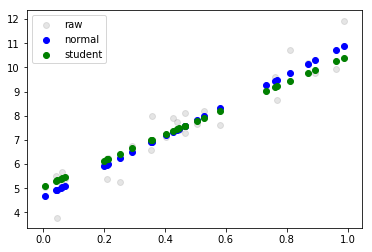

In [31]:
plt.scatter(X_beer.x, y_beer, label = "raw", color="grey", alpha=0.2)
plt.scatter(X_beer.x, y_hat_normal, label = "normal", color="blue")
plt.scatter(X_beer.x, y_hat_student, label = "student", color="green")
plt.legend()

## Answer: Compare the two models performances and comment why it is perhaps appropriate to use the Student's t-distribution instead of the Normal?
- Because the assumption that the noise is a normal distribution is more strict than a t-distribution. And we can see that when test size is not very big, the R^2 score is higher if we use t-distribution than normal distribution.

## Question 2 (continued from HW2) 

Read sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, the model leverages the concept that "patterns from a single-object class lie on a linear subspace."   It also makes use of the idea of linear regression as a problem about projections.  In this case, given a vector $y$, the goal is to find the subspace induced by $\mathrm{Col} \, \mathbf X$ that produced the 'closest' projection vector $\widehat y$ to the original $y$.  

### Question 2a

As discussed in the paper, our face dataset contains cleaned images of faces belonging to different people. Assuming that patterns (faces) from one class (person) are elements of the same subspace, let's try to classify an unknown face using the method presented in the paper.  For each class $i$, we need to:

1. construct the $\mathbf H_i$ hat matrix from known faces, being careful to follow the column concatenation step described in the paper to convert an image into its vector representation;
2. calculate the predicted $\widehat y_i$, the closest vector in $\mathrm{Col} \, \mathbf X_i$ to $y$; and
3. calculate the magnitude of the difference vector between $y$ and $\widehat y_i$.

You should then be able to make a classification decision.

**Notes:**
- Use the provided code to download and re-sample the dataset.
- Follow the normalisation step in the paper to ensure the "maximum pixel value is 1".
- Your classifier should have approximately an 80% accuracy.
- Use the image plotting library of matplotlib to display one (or two) correctly classified faces and the known faces.
- Use the image plotting library of matplotlib to display one (or two) incorrectly classified faces and the known faces.
    
### Question 2b - Significant Faces
Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

In [32]:
from io import BytesIO
from zipfile import ZipFile
import urllib
import os

# Note that you may need to run the following command to install Python Image Library (PIL)
#pip install Pillow
from PIL import Image
import numpy as np
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

/Applications/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [33]:
# starter functions provided to students
def rgb2gray(rgb):
    '''
    function to convert RGB image to gray scale
    accepts 3D numpy array and returns 2D array with same dimensions
    as the first two dimensions of input
    '''
    
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fetch_and_read_data(shape=(50,30)):
    
    '''
    Function to download image data, store in a local folder (note this is 18.4mb), only download the data when
    the local folder is not present, read in the images, downsample them to the specified shape (default = (50x30) (rows x cols))
    and finally split them into a four tuple return object.
    
    Returns:
        - 1) training image data (i.e. images that should form the predictor matrix in your solution)
        - 2) training image data labels (i.e. labels from 1 to 50 that identify which face (1) belongs to)
        - 3) testing image data (i.e. data that you should use to try and classify - note this forms the predictor variable in your regression)
        - 4) testing image data labels (i.e. the labels for (3) - this is to allow you to evaluate your model)
    
    ___________________
    Aside:
    If you want to change the sampling dimensions of your data, pass the shape = (x,y) argument to the method where
    y is the number of columns and x is the number of rows in the image.
    '''
    
    if not os.path.exists('./cropped_faces'):
        url = urllib.request.urlopen("http://www.anefian.com/research/GTdb_crop.zip")
        
        zipfile = ZipFile(BytesIO(url.read()))
        zipfile.extractall()
     
    data = []
    labels = []
    
    files = os.listdir('cropped_faces')
    for f in files:
        if '.jpg' in f:
            image = Image.open('cropped_faces/' + f)
            image = image.resize((shape[1], shape[0]))
            data.append(rgb2gray(np.asarray(image)))
            labels.append(int(f.split('_')[0][1:]) - 1)
            
    data = np.array(data)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels)
    return np.array(trainX), np.array(testX), np.array(trainY), np.array(testY)

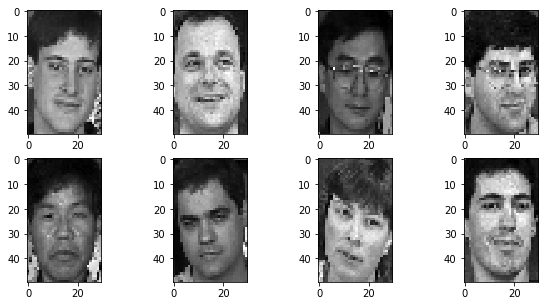

In [34]:
# starter code for the students
train_dataset, test_dataset, train_labels, test_labels = fetch_and_read_data()

# code to plot some of the images
fig, axes = plt.subplots(2,4,figsize=(10,5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[i], cmap='gray') for i in range(len(axes))]
plt.show()

In [35]:
# X0 = train_dataset[train_labels == 0]
# X1 = train_dataset[train_labels == 1]

# X1_concat = X1.swapaxes(1,2).reshape(1500, 12)
# min_max_scaler = MinMaxScaler()

# X1_new = np.zeros((1500, 12))
# for i in range(12):
#     col = min_max_scaler.fit_transform(X1_concat[:,i].reshape(-1,1))
#     X1_new[:,i] = col.reshape(1500)

# X1_concat.shape

# (X1_concat[:,1]).reshape(50, 30)
# plt.imshow(X1_concat[:,1].reshape(30, 50))


### Question 2a Answer

In [36]:
def hat(X):
    return X.dot(np.linalg.inv(X.T.dot(X))).dot(X.T)


Hs = []

for i in range(50):
    X = train_dataset[train_labels == i]
    X_concat = X.swapaxes(1,2).reshape(12, 1500).T
    X_new = np.zeros((1500,12))
    for i in range(12):
        col = min_max_scaler.fit_transform(X_concat[:, i].reshape(-1,1))
        X_new[:,i] = col.reshape(1500)   
    Hs.append( hat(X_new) )
    
    
prediction = [];
for test_img in test_dataset:
    y_hat = []
    
    img_vector = test_img.T.flatten().T
    img_vector = (img_vector - min(img_vector))
    img_vector = img_vector / max(img_vector)
    
    dy = [0]*50
    
    for i in range(50):
        y_hat_i = (Hs[i]).dot(img_vector)
        # y_hat.append( y_hat_i )
        dy[i] = np.linalg.norm(y_hat_i - img_vector)
    
        
    prediction.append( np.argmin( dy )  )

for i in range(len(test_dataset)):
    if test_labels[i] == prediction[i]:
        correct_img = test_dataset[i]
        correct_class = test_labels[i]
        break

for i in range(len(test_dataset)):
    if test_labels[i] != prediction[i]:
        wrong_img = test_dataset[i]
        wrong_class = test_labels[i]
        break
    

print(test_labels)    
print(prediction)

# wrong = ( np.array(test_labels) - np.array(prediction) ).nonzero()

[15  0 17 49 24 31  4  0  8 41 39  1 25 35 35 38 32 46 15 40  9 47 34 39 49
 34  9 37 34 13 20 44  3  7 11 22 21 47 40 39  2 10 10 38 12 45 36 26 37  5
  2 14 18 20 30 26 13 42 37  5 43 35 18 23 44 14  7  9 22 28 29 24 28  7  8
 33 36 44  5 10 40 48 45  8 19  1 31 45 20 33 23 25 23 42 28 41 46 33  4 25
 29 42  4 43 27 30  6  0 49 18 32 31 19 32 16 30 14  3 36 11 17 27 48 27 22
 21 13 19 15 11 12 46  6  3 38 16 24 16  2 48  1 26 47 43 29 12  6 41 21 17]
[15, 0, 6, 49, 24, 31, 4, 0, 13, 41, 3, 1, 25, 35, 35, 38, 32, 46, 3, 40, 9, 47, 28, 39, 49, 34, 9, 37, 17, 13, 20, 4, 28, 8, 11, 22, 21, 47, 32, 7, 2, 21, 1, 22, 12, 24, 36, 26, 37, 5, 2, 14, 18, 20, 30, 26, 2, 42, 37, 5, 43, 35, 18, 23, 47, 14, 7, 9, 22, 28, 29, 6, 22, 7, 28, 33, 36, 0, 27, 22, 40, 48, 45, 8, 19, 1, 31, 45, 17, 33, 23, 25, 23, 42, 28, 41, 46, 33, 4, 25, 29, 42, 4, 15, 27, 30, 6, 34, 49, 0, 32, 13, 19, 32, 17, 30, 14, 3, 36, 11, 17, 27, 48, 27, 22, 0, 13, 19, 3, 11, 12, 46, 6, 3, 38, 16, 24, 16, 2, 48, 1, 26, 47, 43, 29

In [37]:
correct_rate = 1 - ( np.array(test_labels) - np.array(prediction) ).nonzero()[0].shape[0] / test_labels.shape[0]
print("The rate of correct classification is:", correct_rate)

The rate of correct classification is: 0.7733333333333333


In [38]:
print(correct_class)
print(wrong_class)

15
17


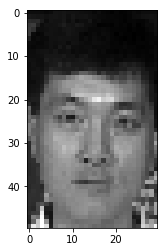

In [39]:
# Correctly Classified Face
plt.imshow(correct_img, cmap='gray')
plt.show()

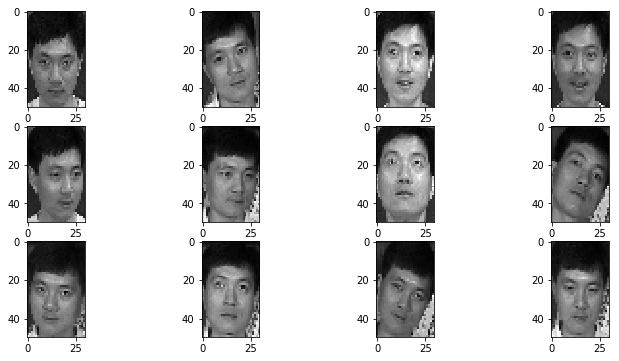

In [40]:
# Known faces
train_class_correct = train_dataset[train_labels == correct_class]
fig, axes = plt.subplots(3,4,figsize=(12,6))
axes = axes.flatten()
[axes[i].imshow(train_class_correct[i], cmap='gray') for i in range(len(axes))]
plt.show()

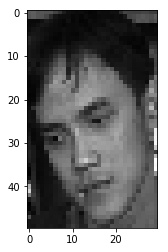

In [41]:
# Incorrectly Classified Face
plt.imshow(wrong_img, cmap='gray')
plt.show()

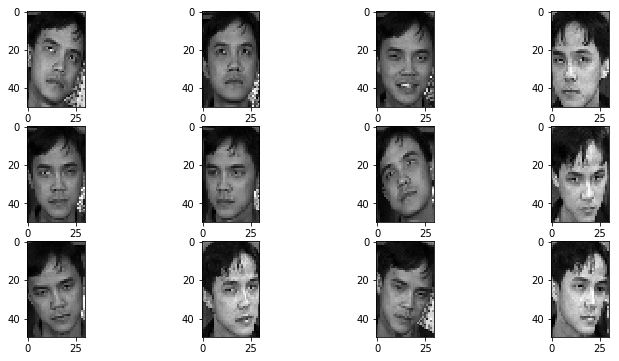

In [42]:
# Known faces
train_class_wrong = train_dataset[train_labels == wrong_class]
fig, axes = plt.subplots(3,4,figsize=(12,6))
axes = axes.flatten()
[axes[i].imshow(train_class_wrong[i], cmap='gray') for i in range(len(axes))]
plt.show()

### Question 2b Answer

In [43]:
train_class_correct = train_dataset[train_labels == correct_class]
images = train_class_correct.swapaxes(1,2).reshape(1500, 12)


for i, col in enumerate(images.T):
    col = col - min(col)
    col = col / max(col)
    images[:,i] = col.T


correct_img_copy = correct_img.copy()
correct_img_copy = correct_img.flatten()



images = sm.add_constant(images)

model = sm.OLS(correct_img_copy, images)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.289
Date:                Wed, 11 Oct 2017   Prob (F-statistic):              0.218
Time:                        21:48:34   Log-Likelihood:                -7633.4
No. Observations:                1500   AIC:                         1.529e+04
Df Residuals:                    1487   BIC:                         1.536e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         63.3279      2.478     25.557      0.000      58.467      68.188
x1           -21.5289     12.168     -1.769      0.077     -45.398       2.340
x2            31.8470     14.191      2.244      0.025       4.011      59.683
x3           -11.2710     14.024     -0.804      0.422     -38.781      16.239
x4             2.4256     13.890      0.175      0.861     -24.819      29.671
x5           -17.5141     14.547     -1.204      0.229     -46.049      11.021
x6            17.8022     13.674      1.302      0.193      -9.019      44.624
x7            -4.6981     13.719     -0.342      0.732     -31.609      22.213
x8            25.5089     14.190      1.798      0.072      -2.326      53.344
x9           -12.1878     14.380     -0.848      0.397     -40.395      16.020
x10            2.1021     14.414      0.146      0.884     -26.172      30.376
x11            3.1964     13.904      0.230      0.818     -24.077      30.470
x12           -2.0692     12.258     -0.169      0.866     -26.114      21.976
==============================================================================
Omnibus:                      724.757   Durbin-Watson:                   0.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.017
Skew:                           0.040   Prob(JB):                     2.55e-18
Kurtosis:                       1.864   Cond. No.                         31.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
temp = results.pvalues.argsort()
ranks = np.empty(len(results.pvalues), int)
ranks[temp] = np.arange(len(results.pvalues))
ranks

most_useful_index = np.argwhere(ranks==1)[0][0]
least_useful_index = np.argwhere(ranks==12)[0][0]
print(most_useful_index)
print(least_useful_index)

2
10


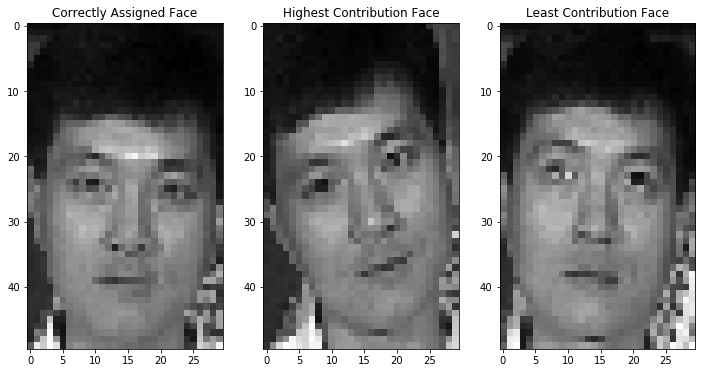

In [45]:
# test face = correct_img

# most useful
most_useful = train_class_correct[most_useful_index-1]
# least useful
least_useful = train_class_correct[least_useful_index-1]

fig, ax = plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(correct_img, cmap='gray')
ax[0].set_title("Correctly Assigned Face")
ax[1].imshow(most_useful, cmap='gray')
ax[1].set_title("Highest Contribution Face")
ax[2].imshow(least_useful, cmap='gray')
ax[2].set_title("Least Contribution Face")
plt.show()

We can see that the face that makes the highest contribution highly resembles the face that we need to assign. However, the least useful face has facial expression much different than the face to be classified.